# Bulding the Rydberg Hamiltonian

This notebook contains the code and data to generate the results for the first part of the paper. This includes only classical stuff.

Structure of the notebook:
- [Build the material structure](#build_material)
- [Build the test/test set](#test_test)
- [Write CRYSTAL input files](#write_input)
- [Read CRYSTAL output files](#read_output)
- [Mapping to the Rydberg Hamiltonian](#mapping_to_ryd)
- [Approximations](#approximations)
- [Compare to QUBO model](#QUBO)
- [Classical Monte Carlo](#monte_carlo)

In [6]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import shutil as sh

from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

from scipy.optimize import minimize
from scipy import constants

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
from scipy.constants import physical_constants
HARTREE_TO_EV = physical_constants['Hartree energy in eV'][0]
BOHR_TO_ANGSTROM = physical_constants['Bohr radius'][0] * 1e10  # Convert meters to Ångstrom
BOHR_CUBED_TO_ANGSTROM_CUBED = BOHR_TO_ANGSTROM**3

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import *
from random_structures import *
from QUBO_models import *

import json
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

eV_to_rad_s = 1.519267447321156e15


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the Material Structure
<a id="build_material"></a>

This section will focus on building the material structure, including relevant parameters and visualizations.

In [7]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])

graphene_mol_r_6_6 = cut_graphene_rectangle(graphene,15,14,center=True)
graphene_mol_r_6_6.remove_sites([1,5,11,18,25,32])
vview(graphene_mol_r_6_6)
# graphene_mol_r_6_6.to_file('/Users/brunocamino/Desktop/UCL/rydberg_atoms/data/structures/graphene_mol_r_6_6.xyz')

Add periodic boundary conditions

In [8]:
cell = np.array([[16.04, -2.134, 0.0],
                [ 0.0, 12.8 ,0.0],
                [0.0, 0.0, 10.0]])
graphene_mol_r_6_6_pbc = Structure(cell, graphene_mol_r_6_6.atomic_numbers, 
                                   graphene_mol_r_6_6.cart_coords, coords_are_cartesian=True)

# vview(graphene_mol_r_6_6_pbc)
# graphene_mol_r_6_6_pbc.to_file('data/crystal/graphene/B_doped/graphene_mol_r_6_6.cif')

## Distance based approach

In [9]:
graphene_opt = read_gui_file('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui')
print(len(SpacegroupAnalyzer(graphene_opt).get_symmetry_operations()))

# graphene_opt.replace(59,'B')
# print(len(SpacegroupAnalyzer(graphene_opt).get_symmetry_operations()))
all_configurations = get_all_configurations(graphene_opt)

156


In [10]:
dm = np.round(graphene_opt.distance_matrix[59],2)
shells = np.unique(dm)[1:]
graphene_tmp = copy.deepcopy(graphene_opt)
for s in shells:
    idx = (np.where(dm == s)[0][0])
    graphene_tmp.replace(59,5)
    graphene_tmp.replace(idx,7)
    

In [11]:
# TRAIN
# Load the input template and indices
with open('data/crystal/graphene/P_doped/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

dm = np.round(graphene_opt.distance_matrix[59],2)
shells = np.unique(dm)[1:]
for i,s in enumerate(shells):
    graphene_tmp = copy.deepcopy(graphene_opt)
    idx = (np.where(dm == s)[0][0])
    # graphene_tmp.replace(59,5)
    # graphene_tmp.replace(idx,7)

# Iterate over the training indices
# for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = idx + 1
    N_N = 1

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, '2\n')

    
    input_template.insert(4 , '60 15\n')
    input_template.insert(5 , f'{N_cry_position} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/P_doped/graphene_mol_r_6_6_h_{N_N}_{i}.d12'
    gui_filename = f'data/crystal/graphene/P_doped/graphene_mol_r_6_6_h_{N_N}_{i}.gui'

    # ONLY RUN ONCE BECAUSE IT OVERWRITES
    # Write the modified template to the output file
    with open(d12_filename, 'w') as file:
        file.writelines(input_template)

    # Copy the GUI file to the output directory
    sh.copy(
        './data/crystal/graphene/P_doped/graphene_mol_r_6_6_pbc.gui',
        gui_filename
    )

    # Print the command for running the script
    print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 20} &')

/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_0 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_1 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_2 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_3 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_4 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_5 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_6 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_7 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_8 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_9 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_10 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_11 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_1

In [12]:
len(shells)

18

## Read energies

In [54]:
dm = np.round(graphene_opt.distance_matrix[59],2)
shells = np.unique(dm)[1:]
E_N = extract_final_energy('data/crystal/reference_states/N2.out') / 2
E_graphene = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')
E_C = E_graphene / 78
E_P = -3.4108644578254E+02*HARTREE_TO_EV

P_energies_dist = []

for i,s in enumerate(shells):  
    # Define output file paths
    out_filename = f'data/crystal/graphene/P_doped/graphene_mol_r_6_6_h_1_{i}.out'
    energy = extract_final_energy(out_filename)
    P_energies_dist.append(energy)
print(len(P_energies_dist))
B_energies_dist = np.array(P_energies_dist)
B_energies_dist = np.delete(P_energies_dist, 9)
shells = np.delete(shells, 9)


18


In [56]:
P_energies_dist-np.max(P_energies_dist)

array([-0.04077895, -0.00533158, -0.01674554, -0.00627699, -0.00260123,
       -0.00206949, -0.00801681, -0.00485128, -0.00400645, -0.00276267,
       -0.00139887, -0.0075171 ,  0.        , -0.00284725, -0.0027402 ,
       -0.00098141, -0.00055027, -0.00552674])

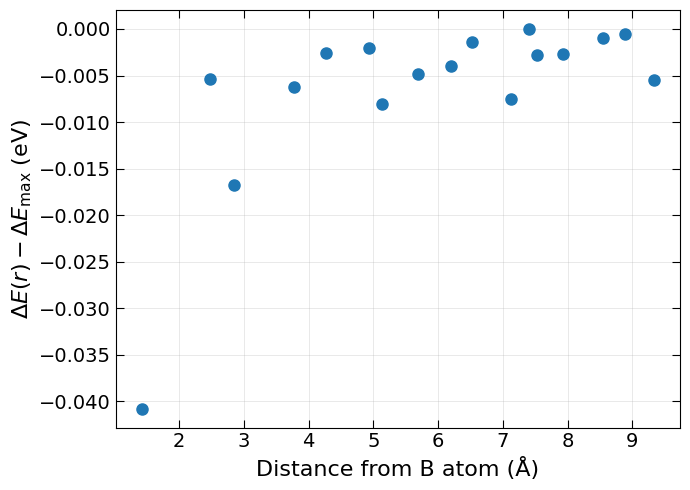

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to arrays
shells_arr = np.array(shells)
energies = np.array(B_energies_dist, dtype=float)  # None → np.nan

# Keep only valid energies
mask = np.isfinite(energies)
shells_plot = shells_arr[mask]
energies_plot = energies[mask]

# --- Normalize w.r.t. the HIGHEST energy ---
E_ref = energies_plot.max()      # highest energy → 0
yvals = energies_plot - E_ref

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(
    shells_plot,
    yvals,
    marker='o',
    markersize=8,
    linestyle='None',
    color='tab:blue'
)

ax.set_xlabel("Distance from B atom (Å)", fontsize=16)
ax.set_ylabel(r"$\Delta E(r) - \Delta E_{\max}$ (eV)", fontsize=16)

ax.tick_params(
    axis='both',
    which='both',
    direction='in',
    top=True,
    right=True,
    labelsize=14,
    length=6
)

ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()

In [15]:
B_energies_dist-np.max(B_energies_dist)

array([-0.04077895, -0.00533158, -0.01674554, -0.00627699, -0.00260123,
       -0.00206949, -0.00801681, -0.00485128, -0.00400645, -0.00139887,
       -0.0075171 ,  0.        , -0.00284725, -0.0027402 , -0.00098141,
       -0.00055027, -0.00552674])

## Heatmap

In [47]:
dm = np.round(graphene_opt.distance_matrix[59],2)
shells = np.unique(dm)[1:]
E_N = extract_final_energy('data/crystal/reference_states/N2.out') / 2
E_graphene = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')
E_C = E_graphene / 78
E_B = -2.4568446300565E+01*HARTREE_TO_EV

P_energies_dist = []

for i,s in enumerate(shells):  
    # Define output file paths
    out_filename = f'data/crystal/graphene/P_doped/graphene_mol_r_6_6_h_1_{i}.out'
    energy = extract_final_energy(out_filename)
    P_energies_dist.append(energy)


B_energies_dist = []

for i,s in enumerate(shells):  
    # Define output file paths
    out_filename = f'data/crystal/graphene/B_doped/distance_based/graphene_mol_r_6_6_h_1_{i}.out'
    energy = extract_final_energy(out_filename)
    B_energies_dist.append(energy)
# print(len(B_energies_dist))
# B_energies_dist = np.array(B_energies_dist)
# B_energies_dist = np.delete(B_energies_dist, 9)
# shells = np.delete(shells, 9)
# shells = shells[:-1]

In [44]:
len(P_energies_dist)

18

[-1.10965181 -0.14507974 -0.45566925 -0.17080565 -0.07078299 -0.05631383
 -0.21814851 -0.13201005 -0.10902119 -0.07517611 -0.03806519 -0.20455077
  0.         -0.07747754 -0.07456453 -0.0267055  -0.01497358 -0.15039031]


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92677/3804718265.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


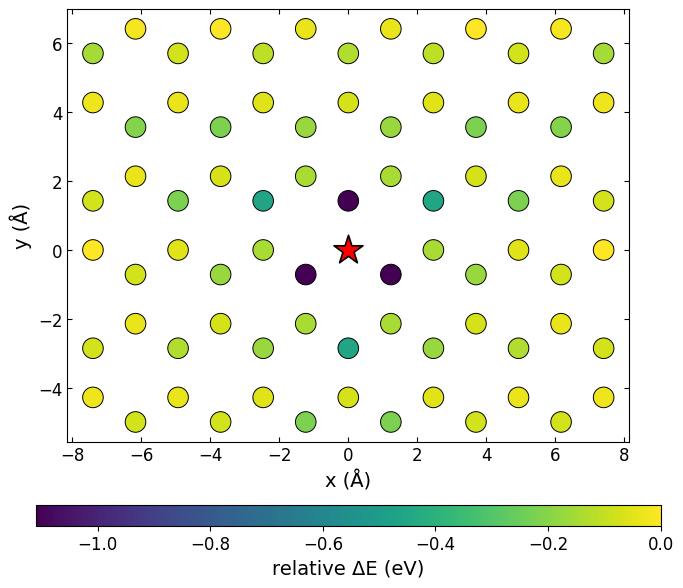

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
B_energies_dist = copy.deepcopy(P_energies_dist)
# -----------------------------------------------------------
# 1) Load coordinates and distance matrix
# -----------------------------------------------------------
coords = graphene_mol_r_6_6_pbc.cart_coords       # shape (78, 3)
distances = graphene_opt.distance_matrix[59]      # distances from atom 59 to all others

# round distances to group equivalent shells
dm = np.round(distances, 2)

# unique shells (excluding 0.0 which is self-distance)
shells = np.unique(dm)[1:]

# -----------------------------------------------------------
# 2) Build energy array: energy of each shell minus the most distant shell
# -----------------------------------------------------------
B_energies_dist = np.array(B_energies_dist)*HARTREE_TO_EV
shell_energy = B_energies_dist - np.max(B_energies_dist)   # normalized as requested
print(shell_energy)
# -----------------------------------------------------------
# 3) Assign each atom the shell energy corresponding to its distance
# -----------------------------------------------------------
atom_energy = np.zeros(coords.shape[0])

for i, s in enumerate(shells):
    mask = dm == s
    atom_energy[mask] = shell_energy[i]

# -----------------------------------------------------------
# 4) Center coordinates so atom 59 is at (0,0)
# -----------------------------------------------------------
coords_centered = coords - coords[59]
x = coords_centered[:, 0]
y = coords_centered[:, 1]

# Mask to EXCLUDE reference atom from the heatmap
ref_index = 59
mask_not_ref = np.arange(coords.shape[0]) != ref_index

x_plot = x[mask_not_ref]
y_plot = y[mask_not_ref]
atom_energy_plot = atom_energy[mask_not_ref]

# -----------------------------------------------------------
# 5) Make heatmap scatter plot
# -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

cmap = get_cmap("viridis")
norm = Normalize(vmin=np.min(atom_energy_plot), vmax=np.max(atom_energy_plot))

# main scatter plot (NO central atom)
sc = ax.scatter(
    x_plot, y_plot,
    c=atom_energy_plot,
    cmap=cmap,
    norm=norm,
    s=220,
    edgecolors='k',
    linewidths=0.7
)

# highlight reference atom (59) *only* as a star, no colormap value
ax.scatter(
    0.0, 0.0,                # centered
    s=480,
    marker='*',
    facecolor='red',
    edgecolor='k',
    linewidths=1.2,
    zorder=10,
    label="Reference atom"
)

# -----------------------------------------------------------
# 6) Horizontal compact colorbar on top
# -----------------------------------------------------------
cbar = fig.colorbar(
    sc, ax=ax,
    orientation='horizontal',
    pad=0.12,          # space between plot and colorbar
    fraction=0.06,     # shrink colorbar
    aspect=30          # longer vs height
)

cbar.set_label("relative ΔE (eV)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# -----------------------------------------------------------
# 7) Axis formatting
# -----------------------------------------------------------
ax.set_aspect('equal')
ax.set_xlabel("x (Å)", fontsize=14)
ax.set_ylabel("y (Å)", fontsize=14)
ax.tick_params(direction='in', top=True, right=True, labelsize=12)

plt.tight_layout()
plt.show()

In [64]:
-1.10965181/HARTREE_TO_EV

-0.04077895186849918

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92677/3038784496.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92677/3038784496.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


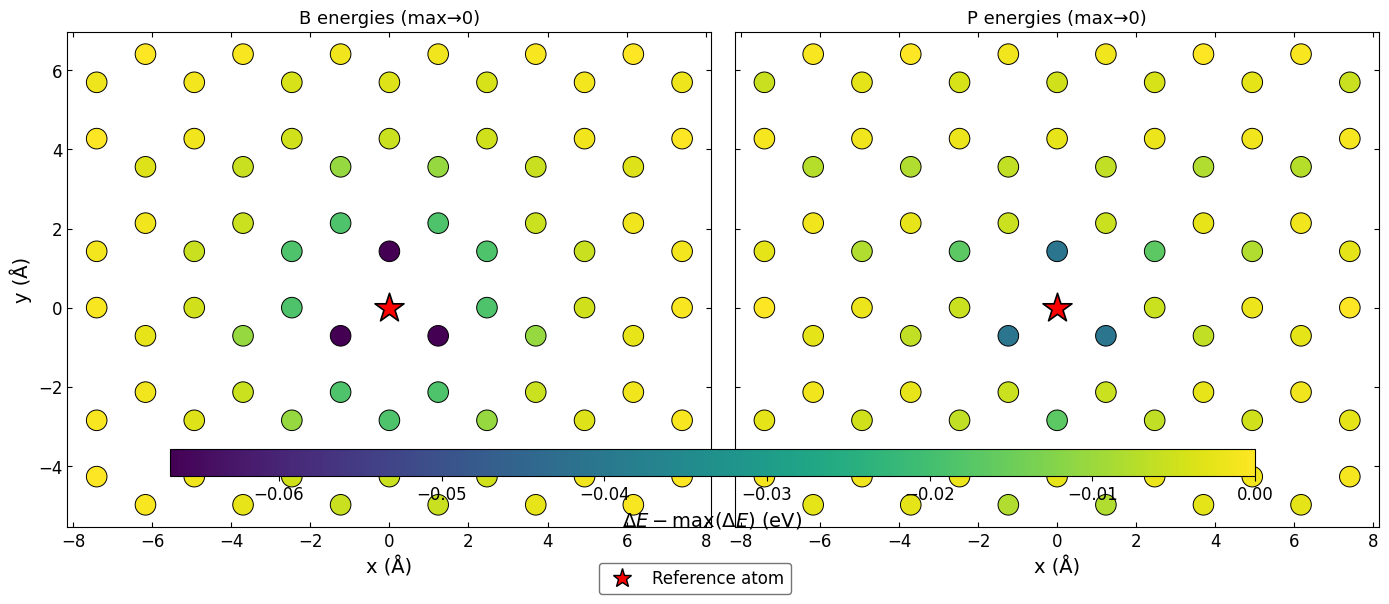

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def plot_B_and_P_heatmaps_1x2_max_zero_shared_scale(
    graphene_mol_r_6_6_pbc,
    graphene_opt,
    B_energies_dist,
    P_energies_dist,
    ref_index=59,
    round_decimals=2,
):
    # -----------------------------------------------------------
    # 1) Coordinates + distance shells
    # -----------------------------------------------------------
    coords = graphene_mol_r_6_6_pbc.cart_coords
    distances = graphene_opt.distance_matrix[ref_index]

    dm = np.round(distances, round_decimals)
    shells = np.unique(dm)[1:]  # exclude self-distance

    B_energies_dist = np.array(B_energies_dist, dtype=float)
    P_energies_dist = np.array(P_energies_dist, dtype=float)

    if len(B_energies_dist) != len(shells):
        raise ValueError(f"B_energies_dist length {len(B_energies_dist)} != number of shells {len(shells)}")
    if len(P_energies_dist) != len(shells):
        raise ValueError(f"P_energies_dist length {len(P_energies_dist)} != number of shells {len(shells)}")

    # -----------------------------------------------------------
    # 2) Normalise each dataset: max -> 0
    # -----------------------------------------------------------
    shell_energy_B = B_energies_dist - np.max(B_energies_dist)
    shell_energy_P = P_energies_dist - np.max(P_energies_dist)

    # -----------------------------------------------------------
    # 3) Assign per-atom energies based on shells
    # -----------------------------------------------------------
    atom_energy_B = np.zeros(coords.shape[0], dtype=float)
    atom_energy_P = np.zeros(coords.shape[0], dtype=float)

    for i, s in enumerate(shells):
        mask = (dm == s)
        atom_energy_B[mask] = shell_energy_B[i]
        atom_energy_P[mask] = shell_energy_P[i]

    # -----------------------------------------------------------
    # 4) Center coords and exclude reference atom from colormap
    # -----------------------------------------------------------
    coords_centered = coords - coords[ref_index]
    x, y = coords_centered[:, 0], coords_centered[:, 1]

    mask_not_ref = np.arange(len(coords)) != ref_index
    x_plot, y_plot = x[mask_not_ref], y[mask_not_ref]
    eB = atom_energy_B[mask_not_ref]
    eP = atom_energy_P[mask_not_ref]

    # -----------------------------------------------------------
    # 5) Shared colour scale: vmax fixed to 0
    # -----------------------------------------------------------
    vmin = float(min(eB.min(), eP.min()))
    vmax = 0.0

    cmap = get_cmap("viridis")
    norm = Normalize(vmin=vmin, vmax=vmax)

    # -----------------------------------------------------------
    # 6) Plot 1×2 with shared axes and shared colourbar
    # -----------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    panels = [
        ("B energies (max→0)", eB),
        ("P energies (max→0)", eP),
    ]

    sc = None
    for ax, (title, data) in zip(axes, panels):
        sc = ax.scatter(
            x_plot, y_plot,
            c=data,
            cmap=cmap,
            norm=norm,
            s=220,
            edgecolors='k',
            linewidths=0.7
        )

        # reference atom as star at origin
        ax.scatter(
            0.0, 0.0,
            s=480,
            marker='*',
            facecolor='red',
            edgecolor='k',
            linewidths=1.2,
            zorder=10,
            label="Reference atom"
        )

        ax.set_aspect('equal')
        ax.set_title(title, fontsize=13)
        ax.set_xlabel("x (Å)", fontsize=14)
        ax.tick_params(direction='in', top=True, right=True, labelsize=12)

    axes[0].set_ylabel("y (Å)", fontsize=14)

    cbar = fig.colorbar(
        sc, ax=axes,
        orientation='horizontal',
        pad=0.10,
        fraction=0.06,
        aspect=40
    )
    cbar.set_label(r"$\Delta E - \max(\Delta E)$ (eV)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    # ---- legend below the plots ----
    handles = [
        plt.Line2D([], [], marker='*', color='red', linestyle='None',
                markersize=14, markeredgecolor='k', label='Reference atom')
    ]

    fig.legend(
        handles=handles,
        loc='lower center',
        ncol=1,
        fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='0.4',
        framealpha=0.9,
        bbox_to_anchor=(0.5, -0.10)  # adjust vertical position if needed
    )
    plt.tight_layout()
    plt.show()

    
plot_B_and_P_heatmaps_1x2_max_zero_shared_scale(
    graphene_mol_r_6_6_pbc,
    graphene_opt,
    B_energies_dist,
    P_energies_dist,
    ref_index=59,
    round_decimals=2,
)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def plot_two_normalisations_1x2_max_zero(
    graphene_mol_r_6_6_pbc,
    graphene_opt,
    B_energies_dist,
    ref_index=59,
    round_decimals=2,
):
    # -----------------------------------------------------------
    # 1) Coordinates + distance shells
    # -----------------------------------------------------------
    coords = graphene_mol_r_6_6_pbc.cart_coords
    distances = graphene_opt.distance_matrix[ref_index]

    dm = np.round(distances, round_decimals)
    shells = np.unique(dm)[1:]  # exclude self-distance

    B_energies_dist = np.array(B_energies_dist, dtype=float)

    # -----------------------------------------------------------
    # 2) Two datasets, each normalised to its OWN maximum = 0
    # -----------------------------------------------------------
    shell_energy_A = B_energies_dist - np.max(B_energies_dist)
    shell_energy_B = B_energies_dist - np.max(B_energies_dist)  # placeholder if different input later

    # -----------------------------------------------------------
    # 3) Assign atom energies
    # -----------------------------------------------------------
    atom_energy_A = np.zeros(coords.shape[0])
    atom_energy_B = np.zeros(coords.shape[0])

    for i, s in enumerate(shells):
        mask = (dm == s)
        atom_energy_A[mask] = shell_energy_A[i]
        atom_energy_B[mask] = shell_energy_B[i]

    # -----------------------------------------------------------
    # 4) Center coordinates, exclude reference atom
    # -----------------------------------------------------------
    coords_centered = coords - coords[ref_index]
    x, y = coords_centered[:, 0], coords_centered[:, 1]

    mask_not_ref = np.arange(len(coords)) != ref_index
    x_plot, y_plot = x[mask_not_ref], y[mask_not_ref]
    eA, eB = atom_energy_A[mask_not_ref], atom_energy_B[mask_not_ref]

    # -----------------------------------------------------------
    # 5) Shared colour scale (max fixed to 0)
    # -----------------------------------------------------------
    vmin = min(eA.min(), eB.min())
    vmax = 0.0

    cmap = get_cmap("viridis")
    norm = Normalize(vmin=vmin, vmax=vmax)

    # -----------------------------------------------------------
    # 6) Plot 1×2
    # -----------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    titles = [
        r"$\Delta E - \max(\Delta E)$ (dataset A)",
        r"$\Delta E - \max(\Delta E)$ (dataset B)",
    ]
    datasets = [eA, eB]

    for ax, data, title in zip(axes, datasets, titles):
        sc = ax.scatter(
            x_plot, y_plot,
            c=data,
            cmap=cmap,
            norm=norm,
            s=220,
            edgecolors='k',
            linewidths=0.7
        )

        # reference atom
        ax.scatter(
            0.0, 0.0,
            s=480,
            marker='*',
            facecolor='red',
            edgecolor='k',
            linewidths=1.2,
            zorder=10
        )

        ax.set_aspect('equal')
        ax.set_title(title, fontsize=13)
        ax.set_xlabel("x (Å)", fontsize=14)
        ax.tick_params(direction='in', top=True, right=True, labelsize=12)

    axes[0].set_ylabel("y (Å)", fontsize=14)

    # -----------------------------------------------------------
    # 7) Shared colourbar
    # -----------------------------------------------------------
    cbar = fig.colorbar(
        sc, ax=axes,
        orientation='horizontal',
        pad=0.10,
        fraction=0.06,
        aspect=40
    )
    cbar.set_label(r"$\Delta E - \max(\Delta E)$ (eV)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

## Two/three N atoms


In [ ]:
#1B2N
E_1B2N = -3.306514966487E+03

In [ ]:
#1B2N_dist
E_1B2N_dist = -3.306443175371E+03

In [65]:
((E_1B2N_dist-E_1B2N)/2*HARTREE_TO_EV)/-1.11

-0.5722892340969593

In [ ]:
#1B3N
E_1B3N = -3.323143043256E+03

In [ ]:
#1B3N_dist
E_1B3N_dist = -3.323043513934E+03

In [66]:
((E_1B3N_dist-E_1B3N)/3*HARTREE_TO_EV)/-1.11

-0.2578931756638363

In [27]:
E_1N_abs =-2.986801782396E+03--2.970196758524E+03
E_1N_abs

-16.605023871999947

In [28]:
(1/343)*100

0.2915451895043732

In [29]:
E_N = extract_final_energy('data/crystal/reference_states/N2.out') / 2
E_graphene = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')
E_C = E_graphene / 78
E_B = -2.4568446300565E+01*HARTREE_TO_EV

In [30]:
85/12


7.083333333333333

## Add Boron atom

In [31]:
graphene_mol_r_6_6_pbc.replace(59,'B')
vview(graphene_mol_r_6_6_pbc)
graphene_mol_r_6_6_pbc.cart_coords

array([[4.23841141e-14, 1.13979296e+01, 0.00000000e+00],
       [4.09329531e-14, 7.12370599e+00, 0.00000000e+00],
       [1.23386207e+00, 9.26081778e+00, 0.00000000e+00],
       [2.46772414e+00, 1.13979296e+01, 0.00000000e+00],
       [3.56318449e-14, 2.84948239e+00, 0.00000000e+00],
       [1.23386207e+00, 4.98659419e+00, 0.00000000e+00],
       [2.46772414e+00, 7.12370599e+00, 0.00000000e+00],
       [3.70158621e+00, 9.26081778e+00, 0.00000000e+00],
       [4.93544828e+00, 1.13979296e+01, 0.00000000e+00],
       [1.23386207e+00, 7.12370599e-01, 0.00000000e+00],
       [2.46772414e+00, 2.84948239e+00, 0.00000000e+00],
       [3.70158621e+00, 4.98659419e+00, 0.00000000e+00],
       [4.93544828e+00, 7.12370599e+00, 0.00000000e+00],
       [6.16931035e+00, 9.26081778e+00, 0.00000000e+00],
       [7.40317242e+00, 1.13979296e+01, 0.00000000e+00],
       [3.70158621e+00, 7.12370599e-01, 0.00000000e+00],
       [4.93544828e+00, 2.84948239e+00, 0.00000000e+00],
       [6.16931035e+00, 4.98659

## Build the Test/test Set
<a id="test_test"></a>

In this section, we'll create the test and train datasets using the prepared material structure.

In [32]:
atom_indices = get_all_configurations(graphene_mol_r_6_6_pbc)

binary_an = []

for n,i in enumerate(np.arange(1,11,1)):
    
    active_sites = np.where(np.array(graphene_mol_r_6_6_pbc.atomic_numbers)==6)[0]
    N_atoms = i
    
    structures_random = generate_random_structures(graphene_mol_r_6_6_pbc,atom_indices=atom_indices,
                                                       N_atoms=N_atoms,
                                                       new_species=7,N_config=100,DFT_config=20,
                                                       return_multiplicity=False,
                                                       active_sites=active_sites)
    print(i,len(structures_random))

    num_structures = len(structures_random)
    for structure in structures_random:
        binary_an_tmp = np.zeros(graphene_mol_r_6_6_pbc.num_sites,dtype='int')
        binary_an_tmp[np.where(np.array(structure.atomic_numbers) == 7)[0]] = 1
        binary_an.append(binary_an_tmp)

binary_an = np.array(binary_an)

# np.savetxt('data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc_index_train.csv',binary_an,delimiter=',',fmt='%d')

1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20


## Write CRYSTAL Input Files
<a id="write_input"></a>

Here, we will generate the input files for the CRYSTAL simulation using the defined structure and parameters.

### Train set

In [33]:
# TRAIN
# Load the input template and indices
with open('data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc_index_train.csv',
    delimiter=','
).astype(int)

# Iterate over the training indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/B_doped/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 20}.d12'
    gui_filename = f'data/crystal/graphene/B_doped/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 20}.gui'

    # ONLY RUN ONCE BECAUSE IT OVERWRITES
    # # Write the modified template to the output file
    # with open(d12_filename, 'w') as file:
    #     file.writelines(input_template)

    # # Copy the GUI file to the output directory
    # sh.copy(
    #     './data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc.gui',
    #     gui_filename
    # )

    # # Print the command for running the script
    # print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 20} &')

### Test set

In [34]:
import copy
import shutil as sh
import numpy as np

# Test
# Load the input template and indices
with open('data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc_index_test.csv',
    delimiter=','
).astype(int)

# Iterate over the testing indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/B_doped/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.d12'
    gui_filename = f'data/crystal/graphene/B_doped/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.gui'


    # # ONLY RUN ONCE BECAUSE IT OVERWRITES
    # # Write the modified template to the output file
    # with open(d12_filename, 'w') as file:
    #     file.writelines(input_template)

    # # Run the following only to generate the input files, then use the
    # # ones generated by the calculation
    
    # # # Copy the GUI file to the output directory
    # sh.copy(
    #     './data/crystal/graphene/B_doped/graphene_mol_r_6_6_pbc.gui',
    #     gui_filename
    # )

    # Print the command for running the script
    print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i%20} &')

/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_0 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_1 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_2 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_3 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_4 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_5 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_6 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_7 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_8 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_9 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_10 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_11 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1_1

## Read Boron structure
<a id="read_boron"></a>


In [35]:
B_reference = Structure.from_file("data/crystal/reference_states/Boron.cif")
# SpacegroupAnalyzer(B_reference).get_conventional_standard_structure()

## Read CRYSTAL Output Files
<a id="read_output"></a>

This section covers how to parse and interpret the output files produced by the CRYSTAL simulation.

In [36]:
E_N = extract_final_energy('data/crystal/reference_states/N2.out') / 2
E_graphene = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')
E_C = E_graphene / 78
E_B = -2.4568446300565E+01*HARTREE_TO_EV


structures_train, energies_train, structures_test, energies_test = process_dataset_B(
    train_folder='data/crystal/graphene/B_doped/train_set/',
    test_folder='data/crystal/graphene/B_doped/test_set/',
    N_sites=78,
    E_N=E_N,
    E_C=E_C,
    E_B= E_B
)

## Mapping to the Rydberg Hamiltonian
<a id="mapping_to_ryd"></a>

We'll map the results from CRYSTAL simulations to the Rydberg Hamiltonian in this section.

In [37]:
1/np.array([1,np.sqrt(3),2,np.sqrt(7),3])**(1/6)

array([1.        , 0.91251475, 0.89089872, 0.85030584, 0.83268318])

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression

def build_H_ryd_with_local(structure, binary_occ, energies, neighbor_counts, scaling_factors):
    """
    Fit a Rydberg 'Ising-like' energy model with:
      E ≈ intercept + J * S_pair(config) + sum_i h_i * x_i
    where
      - x_i ∈ {0,1} is site occupation (Rydberg),
      - S_pair = sum_{i<j} w_ij * x_i * x_j  (weights from neighbor shells).

    Parameters
    ----------
    structure : pymatgen.core.structure.Structure
        Reference structure (cartesian coords used via structure.distance_matrix).
    binary_occ : list[np.ndarray]
        Training configurations; each is length-N vector with 0/1.
    energies : np.ndarray
        Target DFT energies (shape: [n_samples]).
    neighbor_counts : list[int]
        Number of neighbors in each shell (per site) to include (e.g., [6, 12, ...]).
    scaling_factors : list[float]
        Scale/weight for each shell (same length as neighbor_counts).

    Returns
    -------
    model : dict
        {
            "intercept": float,
            "J_pair": float,          # coefficient multiplying S_pair
            "h_local": np.ndarray,    # shape (N,), local detunings per site
            "distance_weights": np.ndarray,  # (N,N) symmetric weight matrix w_ij used for S_pair
            "reg": sklearn LinearRegression object,
            "predict": callable(config) -> float  # fast energy predictor
        }
    """
    # -------- 1) Build shell-weighted interaction mask w_ij --------
    distance_matrix = np.round(structure.distance_matrix, 5)  # (N,N)
    num_sites = structure.num_sites
    sorted_idx = np.argsort(distance_matrix, axis=1)

    # weights per (i,j) selected by shells
    w = np.zeros_like(distance_matrix, dtype=float)
    for i in range(num_sites):
        start = 0
        for shell_idx, num_n in enumerate(neighbor_counts):
            end = start + num_n
            nbrs = sorted_idx[i, start:end]
            w[i, nbrs] = float(scaling_factors[shell_idx])
            start = end

    # Keep symmetric upper triangle for pair sums; zero diagonal
    w = np.triu(w, k=1)
    w = w + w.T  # make symmetric; diagonal stays 0

    # -------- 2) Build design matrix: [ S_pair | x_1 ... x_N ] --------
    X_list = []
    for cfg in binary_occ:
        x = np.asarray(cfg, dtype=float).reshape(-1)
        if x.size != num_sites:
            raise ValueError(f"config length {x.size} != num_sites {num_sites}")
        # S_pair = sum_{i<j} w_ij x_i x_j = 0.5 * x^T (w) x
        S_pair = 0.5 * float(x @ (w @ x))
        # Feature row: [S_pair, x_1, ..., x_N]
        X_list.append(np.concatenate(([S_pair], x)))
    X = np.vstack(X_list)                             # shape (M, 1+N)
    y = np.asarray(energies, dtype=float).reshape(-1) # shape (M,)

    # -------- 3) Fit linear regression --------
    # Intercept captures any baseline offset; local fields capture site detunings.
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    r2 = reg.score(X, y)
    print(f"R²: {r2:.6f}")

    # Coefficients: coef_[0] = J_pair, coef_[1:] = h_local
    J_pair = float(reg.coef_[0])
    h_local = reg.coef_[1:].astype(float)
    intercept = float(reg.intercept_)

    # -------- 4) Fast predictor --------
    def predict(config):
        x = np.asarray(config, dtype=float).reshape(-1)
        if x.size != num_sites:
            raise ValueError(f"config length {x.size} != num_sites {num_sites}")
        S_pair = 0.5 * float(x @ (w @ x))
        return intercept + J_pair * S_pair + float(np.dot(h_local, x))

    return {
        "intercept": intercept,
        "J_pair": J_pair,
        "h_local": h_local,                 # site-resolved detunings
        "distance_weights": w,              # the w_ij actually used
        "reg": reg,
        "predict": predict,
    }

In [39]:
X_train[:,59] 

NameError: name 'X_train' is not defined

In [ ]:
neighbor_count = [3,6,3,3,2]
neighbour_distances = np.array([1,np.sqrt(3),2,np.sqrt(7),3])
scaling_factors = 1/np.power(neighbour_distances,6)

structure = read_gui_file('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui')
structure = SpacegroupAnalyzer(structure).get_symmetrized_structure()
atom_indices_graphene = get_all_configurations(structure)
N_atom = 7

num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene,N_atom)
X_train[:,59] = 1
X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene,N_atom)
X_test[:,59] = 1
# reg_coef = build_H_ryd(structure, X_train, y_train, neighbor_count, scaling_factors)

# y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)
# print(f'Reg coefficient 0 = {reg_coef[0]} eV, Reg coefficient 1 = {reg_coef[1]} eV')
model = build_H_ryd_with_local(structure, X_train, y_train, neighbor_count, scaling_factors)


R²: 0.887915


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial import distance_matrix

def plot_local_detuning_on_graphene(
    coordinates,
    h_local,
    *,
    fixed_idx=None,            # int or list of ints for fixed sites (e.g., boron)
    units_label="m",           # label for coordinate units on axes
    units_scale=1.0,           # multiply coords by this for plotting (e.g., 1e6 for µm)
    draw_bonds=True,           # draw NN bonds
    nn_radius_factor=1.15,     # bond cutoff = nn_radius_factor * d_nn
    point_size=80,             # scatter marker size
    cmap="coolwarm",           # colormap for detuning
    show_colorbar=True,
    figsize=(6,6),
    title="Local detuning on graphene"
):
    """
    Plot graphene sites colored by local detuning h_local, with optional NN bonds and fixed-site highlighting.

    Parameters
    ----------
    coordinates : (N, 2) or (N, 3) array
        Site positions (Cartesian). If (N,3), only x,y are used.
    h_local : (N,) array
        Local detuning values per site (e.g., from the fitted model).
    fixed_idx : int or list[int] or None
        Sites that are fixed (e.g., boron). Highlighted with edgecolor/marker.
    units_label : str
        Axes units text (e.g., "m", "µm").
    units_scale : float
        Multiply coordinates by this before plotting (e.g., 1e6 to convert m -> µm).
    draw_bonds : bool
        If True, draw nearest-neighbor bonds (cutoff = nn_radius_factor * d_nn).
    nn_radius_factor : float
        Bond cutoff factor relative to the minimum nonzero distance.
    point_size : float
        Marker size for scatter points.
    cmap : str
        Matplotlib colormap name.
    """
    coords = np.asarray(coordinates, dtype=float)
    if coords.shape[1] > 2:
        coords = coords[:, :2]  # use x,y only
    h_local = np.asarray(h_local, dtype=float)
    N = coords.shape[0]
    if h_local.shape[0] != N:
        raise ValueError(f"h_local length {h_local.shape[0]} != number of coords {N}")

    # scale coordinates for nicer axes units
    P = coords * float(units_scale)

    # compute nearest-neighbor distance to build a bond cutoff
    dm = distance_matrix(P, P)
    np.fill_diagonal(dm, np.inf)
    d_nn = float(dm.min())
    cutoff = nn_radius_factor * d_nn

    # prepare bonds as segments under the cutoff
    segments = []
    if draw_bonds:
        # Upper triangle only to avoid duplicates
        I, J = np.triu_indices(N, k=1)
        mask = dm[I, J] <= cutoff
        for i, j in zip(I[mask], J[mask]):
            segments.append([P[i], P[j]])

    # figure
    fig, ax = plt.subplots(figsize=figsize)

    # draw bonds (behind points)
    if draw_bonds and segments:
        lc = LineCollection(segments, colors="lightgray", linewidths=1.0, alpha=0.7)
        ax.add_collection(lc)

    # scatter of sites colored by h_local
    sc = ax.scatter(P[:, 0], P[:, 1],
                    c=h_local, s=point_size, cmap=cmap,
                    edgecolors="k", linewidths=0.5)

    # highlight fixed sites (boron) if provided
    if fixed_idx is not None:
        fixed_idx = np.atleast_1d(fixed_idx).astype(int)
        ax.scatter(P[fixed_idx, 0], P[fixed_idx, 1],
                   s=point_size*1.2, facecolors="none", edgecolors="black",
                   linewidths=2.0, label="fixed (B)")

    # colorbar
    if show_colorbar:
        cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Local detuning $h_i$ (arb. units)")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel(f"x ({units_label})")
    ax.set_ylabel(f"y ({units_label})")
    ax.set_title(title)
    ax.grid(alpha=0.2, linestyle=":")
    if fixed_idx is not None:
        ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # return d_nn in plotting units for reference
    return {"d_nn": d_nn, "cutoff": cutoff}

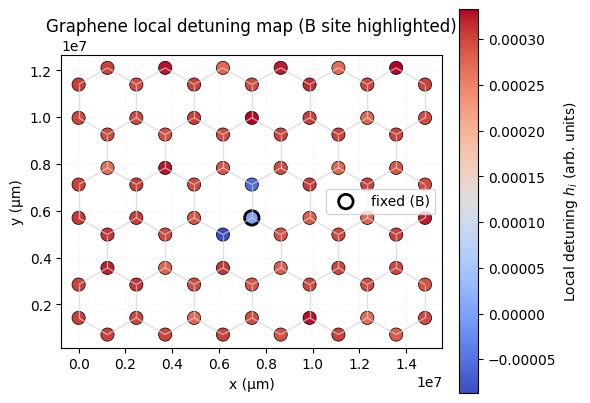

Estimated NN distance on plot: 1424741.137 µm


In [ ]:
# Suppose:
#   coordinates: (N,2)/(N,3) array in meters
#   model: dict returned by build_H_ryd_with_local(...)
#   boron_idx: integer index of the boron site
coordinates = np.array([[4.23841141e-14, 1.13979296e+01, 0.00000000e+00],
       [4.09329531e-14, 7.12370599e+00, 0.00000000e+00],
       [1.23386207e+00, 9.26081778e+00, 0.00000000e+00],
       [2.46772414e+00, 1.13979296e+01, 0.00000000e+00],
       [3.56318449e-14, 2.84948239e+00, 0.00000000e+00],
       [1.23386207e+00, 4.98659419e+00, 0.00000000e+00],
       [2.46772414e+00, 7.12370599e+00, 0.00000000e+00],
       [3.70158621e+00, 9.26081778e+00, 0.00000000e+00],
       [4.93544828e+00, 1.13979296e+01, 0.00000000e+00],
       [1.23386207e+00, 7.12370599e-01, 0.00000000e+00],
       [2.46772414e+00, 2.84948239e+00, 0.00000000e+00],
       [3.70158621e+00, 4.98659419e+00, 0.00000000e+00],
       [4.93544828e+00, 7.12370599e+00, 0.00000000e+00],
       [6.16931035e+00, 9.26081778e+00, 0.00000000e+00],
       [7.40317242e+00, 1.13979296e+01, 0.00000000e+00],
       [3.70158621e+00, 7.12370599e-01, 0.00000000e+00],
       [4.93544828e+00, 2.84948239e+00, 0.00000000e+00],
       [6.16931035e+00, 4.98659419e+00, 0.00000000e+00],
       [7.40317242e+00, 7.12370599e+00, 0.00000000e+00],
       [8.63703449e+00, 9.26081778e+00, 0.00000000e+00],
       [9.87089657e+00, 1.13979296e+01, 0.00000000e+00],
       [6.16931035e+00, 7.12370599e-01, 0.00000000e+00],
       [7.40317242e+00, 2.84948239e+00, 0.00000000e+00],
       [8.63703449e+00, 4.98659419e+00, 0.00000000e+00],
       [9.87089657e+00, 7.12370599e+00, 0.00000000e+00],
       [1.11047586e+01, 9.26081778e+00, 0.00000000e+00],
       [1.23386207e+01, 1.13979296e+01, 0.00000000e+00],
       [8.63703449e+00, 7.12370599e-01, 0.00000000e+00],
       [9.87089657e+00, 2.84948239e+00, 0.00000000e+00],
       [1.11047586e+01, 4.98659419e+00, 0.00000000e+00],
       [1.23386207e+01, 7.12370599e+00, 0.00000000e+00],
       [1.35724828e+01, 9.26081778e+00, 0.00000000e+00],
       [1.48063448e+01, 1.13979296e+01, 0.00000000e+00],
       [1.11047586e+01, 7.12370599e-01, 0.00000000e+00],
       [1.23386207e+01, 2.84948239e+00, 0.00000000e+00],
       [1.35724828e+01, 4.98659419e+00, 0.00000000e+00],
       [1.48063448e+01, 7.12370599e+00, 0.00000000e+00],
       [1.35724828e+01, 7.12370599e-01, 0.00000000e+00],
       [1.48063448e+01, 2.84948239e+00, 0.00000000e+00],
       [4.12832119e-14, 9.97318838e+00, 0.00000000e+00],
       [1.23386207e+00, 1.21103002e+01, 0.00000000e+00],
       [4.11643185e-14, 5.69896479e+00, 0.00000000e+00],
       [1.23386207e+00, 7.83607659e+00, 0.00000000e+00],
       [2.46772414e+00, 9.97318838e+00, 0.00000000e+00],
       [3.70158621e+00, 1.21103002e+01, 0.00000000e+00],
       [3.42533869e-14, 1.42474120e+00, 0.00000000e+00],
       [1.23386207e+00, 3.56185299e+00, 0.00000000e+00],
       [2.46772414e+00, 5.69896479e+00, 0.00000000e+00],
       [3.70158621e+00, 7.83607659e+00, 0.00000000e+00],
       [4.93544828e+00, 9.97318838e+00, 0.00000000e+00],
       [6.16931035e+00, 1.21103002e+01, 0.00000000e+00],
       [2.46772414e+00, 1.42474120e+00, 0.00000000e+00],
       [3.70158621e+00, 3.56185299e+00, 0.00000000e+00],
       [4.93544828e+00, 5.69896479e+00, 0.00000000e+00],
       [6.16931035e+00, 7.83607659e+00, 0.00000000e+00],
       [7.40317242e+00, 9.97318838e+00, 0.00000000e+00],
       [8.63703449e+00, 1.21103002e+01, 0.00000000e+00],
       [4.93544828e+00, 1.42474120e+00, 0.00000000e+00],
       [6.16931035e+00, 3.56185299e+00, 0.00000000e+00],
       [7.40317242e+00, 5.69896479e+00, 0.00000000e+00],
       [8.63703449e+00, 7.83607659e+00, 0.00000000e+00],
       [9.87089657e+00, 9.97318838e+00, 0.00000000e+00],
       [1.11047586e+01, 1.21103002e+01, 0.00000000e+00],
       [7.40317242e+00, 1.42474120e+00, 0.00000000e+00],
       [8.63703449e+00, 3.56185299e+00, 0.00000000e+00],
       [9.87089657e+00, 5.69896479e+00, 0.00000000e+00],
       [1.11047586e+01, 7.83607659e+00, 0.00000000e+00],
       [1.23386207e+01, 9.97318838e+00, 0.00000000e+00],
       [1.35724828e+01, 1.21103002e+01, 0.00000000e+00],
       [9.87089657e+00, 1.42474120e+00, 0.00000000e+00],
       [1.11047586e+01, 3.56185299e+00, 0.00000000e+00],
       [1.23386207e+01, 5.69896479e+00, 0.00000000e+00],
       [1.35724828e+01, 7.83607659e+00, 0.00000000e+00],
       [1.48063448e+01, 9.97318838e+00, 0.00000000e+00],
       [1.23386207e+01, 1.42474120e+00, 0.00000000e+00],
       [1.35724828e+01, 3.56185299e+00, 0.00000000e+00],
       [1.48063448e+01, 5.69896479e+00, 0.00000000e+00],
       [1.48063448e+01, 1.42474120e+00, 0.00000000e+00]])
h_local = model["h_local"]

# Plot in micrometers, draw bonds up to ~1.15×NN distance, mark boron
info = plot_local_detuning_on_graphene(
    coordinates=coordinates,
    h_local=h_local,
    fixed_idx=59,     # or [boron_idx] if you prefer
    units_label="µm",
    units_scale=1e6,         # m -> µm
    draw_bonds=True,
    nn_radius_factor=1.15,
    point_size=90,
    cmap="coolwarm",
    title="Graphene local detuning map (B site highlighted)"
)

print(f"Estimated NN distance on plot: {info['d_nn']:.3f} { 'µm' }")

In [ ]:
SpacegroupAnalyzer(graphene_mol_r_6_6_pbc,symprec=1.).get_symmetry_operations()

[SymmOp(self.affine_matrix=array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])),
 SymmOp(self.affine_matrix=array([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.]]))]

In [ ]:
import scipy
scipy.special.comb(78,5)

21111090.0

Reg coefficient 0 = 0.0003613877583255407, Reg coefficient 1 = 0.00020311860082042723

#### Periodic

In [ ]:
# Calculate the predicted energies
y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Percentage MSE relative to mean squared value
mse_percent = 100 * mse / np.mean(np.square(y_test))

print(f"Mean Squared Error (MSE): {mse:.6e}")
print(f"Percentage MSE (relative to ⟨y²⟩): {mse_percent:.2f}%")

# Spearman's rank correlation
rho, p_value = spearmanr(y_pred, y_test)
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho:.4f}")
print(f"P-value: {p_value:.4e}")

Mean Squared Error (MSE): 9.812205e-08
Percentage MSE (relative to ⟨y²⟩): 1.90%
Spearman's Rank Correlation Coefficient (ρ): 0.9862
P-value: 0.0000e+00


#### Molecule

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the predicted energies
y_pred = calculate_Ryd_energy_mol(structure, X_test, reg_coef, scaling_factors)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Percentage MSE relative to mean squared value
mse_percent = 100 * mse / np.mean(np.square(y_test))

print(f"Mean Squared Error (MSE): {mse:.6e}")
print(f"Percentage MSE (relative to ⟨y²⟩): {mse_percent:.2f}%")

# Spearman's rank correlation
rho, p_value = spearmanr(y_pred, y_test)
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho:.4f}")
print(f"P-value: {p_value:.4e}")



Mean Squared Error (MSE): 9.144934e-08
Percentage MSE (relative to ⟨y²⟩): 1.77%
Spearman's Rank Correlation Coefficient (ρ): 0.9846
P-value: 0.0000e+00


### Energy to R

In [ ]:
# Given values
C6 = 5.42e-24  # C6 constant in rad m^6 / s

coulomb_interaction = reg_coef[1] * eV_to_rad_s  # Calculate coulomb interaction

# Calculate R
R = (C6 / coulomb_interaction) ** (1 / 6)  # R in meters

# Convert R to micrometers (1 meter = 1e6 micrometers)
R_micrometers = R * 1e6

# Print R in micrometers
print(f"R in micrometers: {R_micrometers:.12f} µm")

R in micrometers: 1.612263020561 µm


# THE END